# Project: Investigate a Dataset - [No-show appointments]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This data set contains info about 110,528 rows For patients who have diseases such as diabetes,Hypertension, alcoholism and there location ,We need to know which patients show up for their appointments and who don't.

### Columns of Soccer Database of dataset:
- PatientId : a unique identifier for each patient.
- AppointmentID :a unique identifier for patient Appointment.
- Gender : the type of the patient male or female.
- ScheduledDay : the time of patient Appointment.
- AppointmentDay : the date of patient Appointment.
- Age : the patient age.
- Neighbourhood : the patient location where he stay.
- Scholarship : Reducing the ticket price for the patient.
- diabetes,Hypertension, alcoholism,handcap : group of diseases.
- SMS_received : sms message that sent for patient.
- No-show : Patients who attended and those who did not.
### Question(s) for Analysis
- What influences a no-show :
- Does age affect No show of patients?
- Do Diabetes affect No show of patients
- Do Gender affect No show of patients ?
- Do Neighbourhood affect No show of patients?
- Do SMS_received affect No show of patients ?

In [2]:
# here we import some libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

- we will read and show our data and identify our problem to solve it.

### General Properties
- here we read our data and show first 5 rows to see it
- we shape data to see our dismensions rows and coulmns
- we get information and describe our data to check the missing and null values
- we remove null and duplicated values 

In [3]:
# here we read our data 
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
# here we show the first 5 rows 
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# here we shape our data to know how rows and coulmns that we have (the dismensions)
df.shape

(110527, 14)

- we find here we have 14 coulmns and 110527 rows

In [5]:
# here we look for our data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


- here we notice that we do not have missing data

In [6]:
# here we check our data min,max,mean,standard deviation and count
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


- we notice in coulmns Age the min number is -1 and max is 115 there are invalid number for age
- we notice that in all diseases have 0.000000 at min,25%,50%,75

# Data Cleaning

In [7]:
# we check duplicated rows in (PatientId) coulmns
df.duplicated(['PatientId']).sum()

48228

- there are 48228 duplicated rows we need to remove

In [8]:
# now we will remove the duplicates rows to obtain unique id patient
df.drop_duplicates(['PatientId'], inplace=True)

In [9]:
# here we delete Unnecessary data
df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], axis=1 ,inplace=True)
# we show after our dropping
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


- first we remove the duplicates rows for have a unique id patient 
- Secondly we delete Unnecessary columns that we do not use

In [10]:
# here we show invalid row to clean it 
df.query('Age=="-1"')

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,F,-1,ROMÃO,0,0,0,0,0,0,No


In [11]:
# here we remove this row to clean data 
df.drop(99832 , inplace=True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [12]:
# we check number of rows now after removing
df.shape

(62298, 10)

- now here we have 10 coulmns from 14 and 62299 rows from 110527

In [13]:
# we need to know how many the null values
df.isnull().sum()

Gender           0
Age              0
Neighbourhood    0
Scholarship      0
Hipertension     0
Diabetes         0
Alcoholism       0
Handcap          0
SMS_received     0
No-show          0
dtype: int64

- we notice that there is no Null data or missing data 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62298 entries, 0 to 110524
Data columns (total 10 columns):
Gender           62298 non-null object
Age              62298 non-null int64
Neighbourhood    62298 non-null object
Scholarship      62298 non-null int64
Hipertension     62298 non-null int64
Diabetes         62298 non-null int64
Alcoholism       62298 non-null int64
Handcap          62298 non-null int64
SMS_received     62298 non-null int64
No-show          62298 non-null object
dtypes: int64(7), object(3)
memory usage: 5.2+ MB


- here we see there is no missing values after our last operation itis clean now

<a id='eda'></a>
## Exploratory Data Analysis

## Question(s) for Analysis

- What influences a no-show :
- Does age affect No show of patients?
- Do Diabetes affect No show of patients
- Do Gender affect No show of patients ?
- Do Neighbourhood affect No show of patients?
- Do SMS_received affect No show of patients ?


### Research Question 1 (Does age affect No show of patients?!)

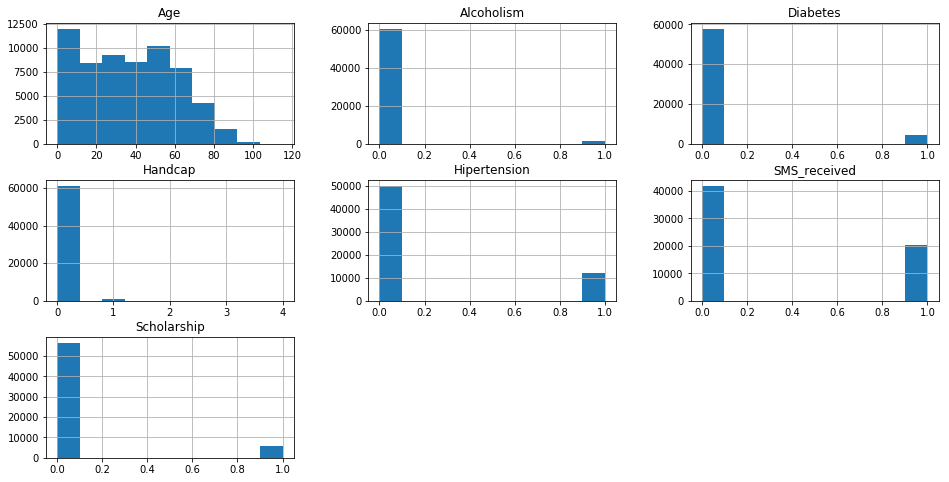

In [15]:
#here we visualize our data with histograms
df.hist(figsize=(16,8));

## we notice that
- in Age left skewed and it mean from 40 to 60
- in alcoholism most people has no alcoholism
- in diabetes most people has no diabetes
- in handcap most people has no handcap
- in hipertension most people has no hipertension
- in sms_received more than 40000 received sms and half of them do not received
- in scolarship most people has no scolarship

In [6]:
# we rename no-show columns to No_show to avoid Syntax error
df.rename(columns={'No-show':'No_show'},inplace=True)

In [7]:
# dividing the patients to 2 groups showing and no showing
show = df.No_show == "No"
no_show = df.No_show == "Yes"

In [76]:
# we calc the means of age of people that show 
df.Age[show].mean()

37.401975850713505

In [77]:
# we calc the means of age of people that NO show 
df.Age[no_show].mean()

33.843434757647827

- we notice that the mean age of people that show is bigger than people than no show But the mean for both is still similar

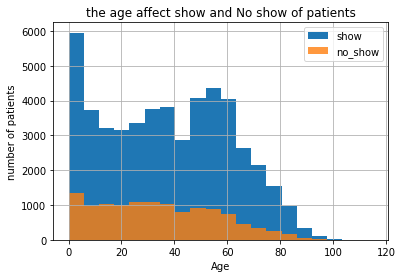

In [47]:
# here we visualize the Age of people they show and no show by histogram
df.Age[show].hist(alpha=1,bins=20,label='show')
df.Age[no_show].hist(alpha=0.8,bins=20,label='no_show')
plt.title('the age affect show and No show of patients')
plt.xlabel('Age')
plt.ylabel('number of patients')
plt.legend();

- we notice the show of The patients in all Ages is more than the No show of The patients Ages
- Therefore, age does not affect patients' No show

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Do Diabetes affect No show of patients !)

In [95]:
df.Diabetes[no_show].mean()

0.06233084556712868

In [96]:
df.Diabetes[show].mean()

0.072966769783454746

- The mean for both is almost the same

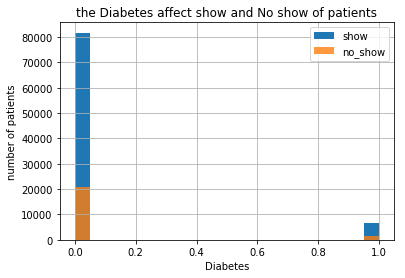

In [24]:
# here we visualize hipertension columns in show and no show by histogram
df.Diabetes[show].hist(alpha=1,bins=20,label='show')
df.Diabetes[no_show].hist(alpha=0.8,bins=20,label='no_show')
def label(x,y,t):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend();
label("Diabetes","number of patients","the Diabetes affect show and No show of patients")

- we notice that most of people did not have Diabetes 
- we notice people they show is more than people no show 
- This applies to the rest of the diseases because according to the previous information, more than 75% of people do not suffer from any kind of disease.

### Research Question 3  (Do Gender affect No show of patients !)

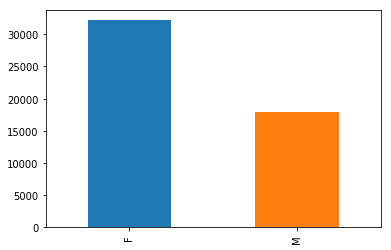

In [141]:
# we want to know the number of male and female
df.Gender[no_show].value_counts().plot('bar')
df.Gender[show].value_counts().plot('bar');

- we see female is more than 30000 and male less than 20000

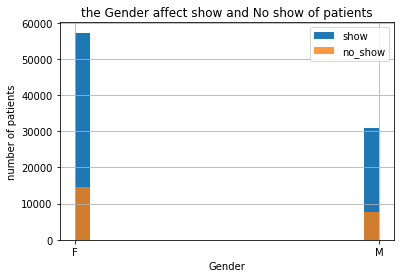

In [28]:
# here we visualize Gender columns in  show and no show by histogram
df.Gender[show].hist(alpha=1,bins=20,label='show')
df.Gender[no_show].hist(alpha=0.8,bins=20,label='no_show')
def label5(x,y,t):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend();
label5("Gender","number of patients","the Gender affect show and No show of patients")

- we notice that number of females are more than number of males
- females are show are more than females are no show
- males are show are more than males they no show
- in general females show are more than males show it is clear in our histogram

### Research Question 4  (Do Neighbourhood affect No show of patients !)

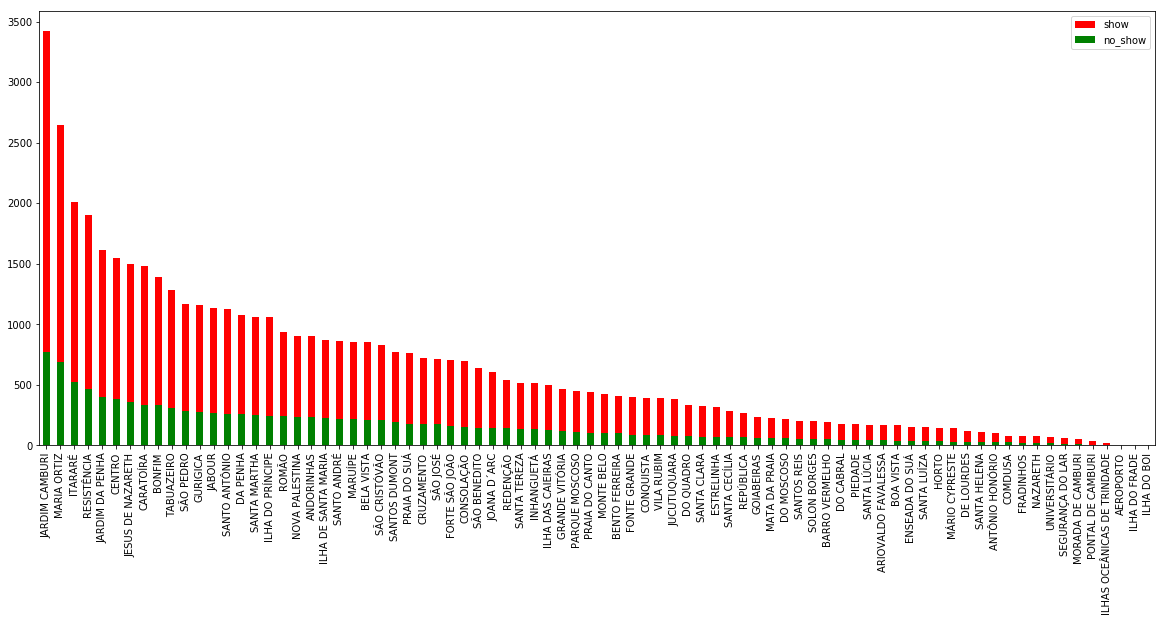

In [131]:
#  here we visualize Neighbourhood columns by bar plot
plt.figure(figsize=[20,8])
df.Neighbourhood[show].value_counts().plot('bar',label='show',color='red')
df.Neighbourhood[no_show].value_counts().plot('bar',label='no_show',color='green')
plt.legend();

- we notice that the number of patients in each Neighbourhood is Different
- and number of show and no show in each Neighbourhood is Different too
- so we think there is affect No show in far places and affect show in near places

### Research Question 5  (Do SMS_received affect No show of patients !)

In [158]:
# we want to know how many people are received sms and do not received
df[show].SMS_received.value_counts()

0    35202
1    14903
Name: SMS_received, dtype: int64

- we see there are more than 35000 person do not received sms and less half of them are received

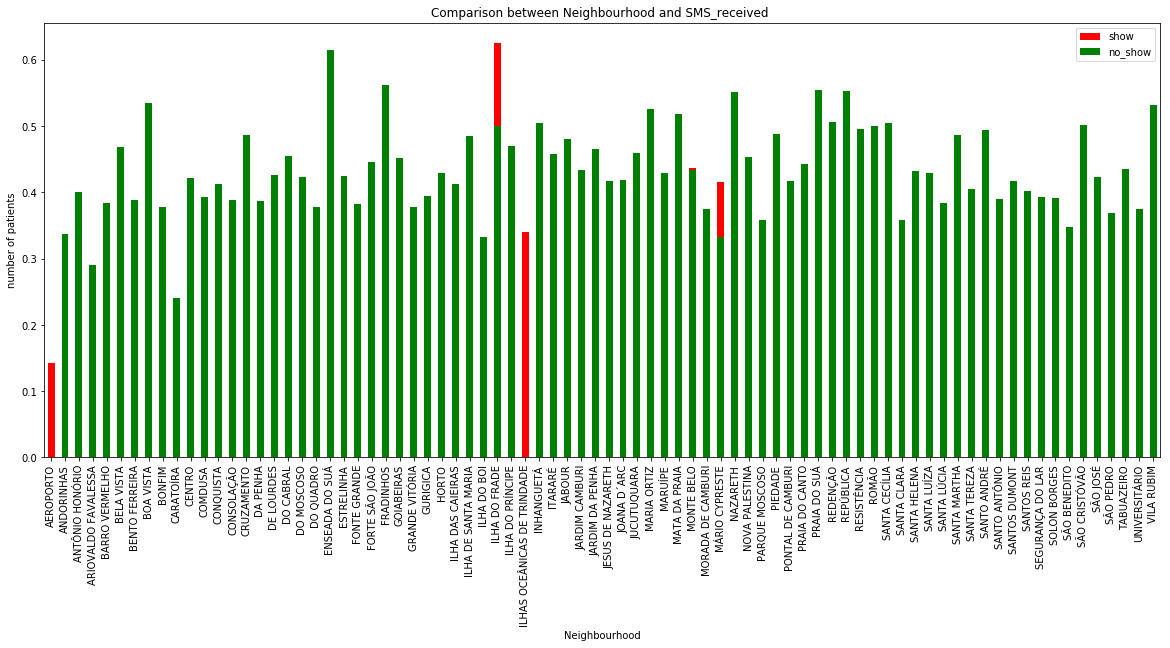

In [27]:
# we show the relationship between Neighbourhood and SMS_received
plt.figure(figsize=[20,8])
df[show].groupby('Neighbourhood').SMS_received.mean().plot('bar',label='show',color='red')
df[no_show].groupby('Neighbourhood').SMS_received.mean().plot('bar',label='no_show',color='green')
def label2(x,y,t):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend();
label2("Neighbourhood","number of patients","Comparison between Neighbourhood and SMS_received ")

- we see patients they received sms and show are very less , sms response only 5 Neighbourhood
- and patients they received sms and no show are very big 
- we think that most of no show people did not received sms

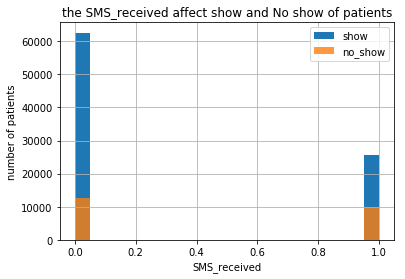

In [26]:
df.SMS_received[show].hist(alpha=1,bins=20,label='show')
df.SMS_received[no_show].hist(alpha=0.8,bins=20,label='no_show')
def label3(x,y,t):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend();
    plt.show()
label3("SMS_received","number of patients","the SMS_received affect show and No show of patients")

- we see more than 35000 person did not received sms but more than 28000 person are show
- and 15000 person received sms most of them are show 
- so i think SMS_received do not have a big affect in show patient

<a id='conclusions'></a>
## Conclusions
- 1- Age does not affect No show of patients, as in all ages the number of patients who show  is higher than those who do No show
- 2- Diabetes does not affect Because most people did not have Diabetes ,and on the other hand people they have Diabetes are show more than people they No show
- 3- Gender does not affect Because those who show are much more than those who do not show , whether men or women
- 4- Neighbourhood  there is affect No show in far places and affect show in near places
- 5- SMS_received with Neighbourhood no have a big affect because it response in only 5 Neighbourhood from the all 
- 6- SMS_received only it no affect becuase most people are show do not received sms 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])